<a href="https://www.kaggle.com/code/siddp6/cifar-10-cnn?scriptVersionId=138717127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

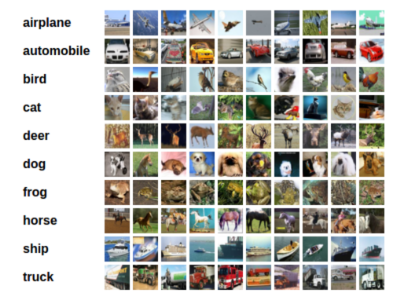

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch 
import numpy as np

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')    

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

Note that of course:

- The resize and crop should be the same as applied during training for best performance
- The normalization should be the same between training and inference (validation and test)

In [2]:
import torchvision.transforms as T
import multiprocessing

num_workers = multiprocessing.cpu_count()
batch_size = 64
valid_size = .2

# These are the per-channel mean and std of CIFAR-10 over the dataset
mean = (0.49139968, 0.48215827, 0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)
    
train_transforms = T.Compose([
    T.Resize(40),
    T.RandomCrop(32),
    T.RandomHorizontalFlip(.5),
    T.RandAugment(num_ops=2, magnitude=15, interpolation=T.InterpolationMode.BILINEAR),
    T.transforms.ToTensor(),
    T.transforms.Normalize(mean, std)
])

val_transforms = T.Compose([
    T.Resize(40),
    T.RandomCrop(32),
    T.transforms.ToTensor(),
    T.transforms.Normalize(mean, std)
])

test_transforms = T.Compose([
    T.Resize(40),
    T.RandomCrop(32),
    T.transforms.ToTensor(),
    T.transforms.Normalize(mean, std)
])

In [3]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

root = "data"

train_data = datasets.CIFAR10(root, train=True, download=True, transform=train_transforms)
valid_data = datasets.CIFAR10(root, train=True, download=True, transform=val_transforms)
test_data = datasets.CIFAR10(root, train=False, download=True, transform=test_transforms)


shuffled_indices = torch.randperm(len(train_data)) # Random index [0,len(train_data)-1]
train_idx, valid_idx = shuffled_indices[:int(len(shuffled_indices)*.8)], shuffled_indices[int(len(shuffled_indices)*.8):]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
    
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=batch_size, num_workers=num_workers
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

NOTE: 
- It is important to use BatchNorm before DropOut. 
- The latter drops some connections only at training time, so placing it before BatchNorm would cause the distribution seen by BatchNorm to be different between training and inference.

In [5]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_classes = 10):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),  
            
            nn.Linear(128 * 2 * 2, 500), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            
            nn.Linear(500, n_classes),
            
        )
    
    def forward(self, X):
        return self.model(X)

In [6]:
model = Net()
if train_on_gpu:
    model.cuda()
print(model)

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): R

## How many parameters?

Now that you built the network, can you compute with pen and paper how many parameters does your network have? Does your answer match the output of the following cell?

In [7]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

360430

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5)

## Visualize your network (optional)

You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "cifar10_network.pt" in this directory), then download the produced `cifar10_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [9]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

---
# Learning Rate Finder

Before we start our training, let's find a range for the learning rate that makes sense for our situation. We will use the learning rate finder that we've seen in one of the previous videos:

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm


def lr_finder(min_lr, max_lr, n_steps, criterion, optimizer, model, train_loader):
    torch.save(model.state_dict(), "__weights_backup")
    r = np.power(max_lr / min_lr, 1 / (n_steps - 1))
    losses = dict()
    train_loss = 0.0
    
    lr_scheduler = LambdaLR(optimizer, lr_lambda = lambda epoch: epoch**r)
    model.train()
    
    for batch_idx, (data, target) in tqdm(
            enumerate(train_loader),
            desc="Training",
            total=len(train_loader),
            leave=True,
            ncols=80,
        ):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()  
        output = model(data)  
        loss = criterion(output, target)  
        loss.backward()  
        optimizer.step()  

        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss.item() - train_loss)
        )
        
        losses[lr_scheduler.get_last_lr()[0]] = train_loss
        
        if train_loss / min(losses.values()) > 10:
            break
        elif batch_idx == n_steps - 1:
            break
        else:
            lr_scheduler.step()
            
    model.load_state_dict(torch.load("__weights_backup"))
    
    return losses
    
    

In [ ]:
min_lr = 1e-5
max_lr = 1
total_train_batches = len(train_loader)
n_steps = total_train_batches

In [ ]:
losses = lr_finder(min_lr, max_lr, n_steps, criterion, optimizer, model, train_loader)

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])


# Learning Rate Scheduler + Hyperparameter Optimization
Let's also use two other tricks we have just learned: the learning rate scheduler, that changes the learning rate as the training progresses, and the hyperparameter optimization that optimizes the choices to maximize performance.

Let's start by writing an optimize function that leverages the Learning Rate scheduler:

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [10]:
!pip install livelossplot

In [11]:
import matplotlib.pyplot as plt
# This is a plotting function
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

In [12]:
from livelossplot import PlotLosses
from tqdm import tqdm
import utility
from livelossplot.outputs import MatplotlibPlot

def run_model(model, epochs, train_loader, val_loader, optimizer, criterion, save_path, is_cuda=False, interactive_tracking=False):
    
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None
    
    val_loss_min = None
    logs = {}
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", verbose=True, threshold=.01)

    for epoch in tqdm(
            range(epochs),
            desc="Epochs",
            total=epochs,
            leave=True,
            ncols=80
        ):
        train_loss = utility.run(
            model=model, 
            optimizer=optimizer, 
            criterion=criterion,
            data_loader=train_loader, 
            is_cuda=is_cuda, 
            mode="Train"
        )
        val_loss = utility.run(
            model=model, 
            optimizer=None, 
            criterion=criterion,
            data_loader=train_loader, 
            is_cuda=is_cuda, 
            mode="Val"
        )
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch + 1, train_loss, val_loss
            )
        ) 
        
        if val_loss_min is None or ((val_loss_min - val_loss) / val_loss_min > 0.1):
            torch.save(model.state_dict(), save_path)
            val_loss_min = val_loss
        
        scheduler.step(val_loss)
        
        if interactive_tracking:
            logs['loss'] = train_loss
            logs['val_loss'] = val_loss
            liveloss.update(logs)
            liveloss.send()

In [ ]:
run_model(model, 3, train_loader, valid_loader, optimizer, criterion, save_path="cifar10_best_valid.pt", is_cuda=train_on_gpu, interactive_tracking=True)

###  Load the Model with the Lowest Validation Loss

In [13]:
model.load_state_dict(torch.load("cifar10_best_valid.pt"))

<All keys matched successfully>

In [16]:
import utility
test_loss, preds, actuals, class_correct, class_total = utility.test_run(model, criterion, test_loader, train_on_gpu)

Testing: 100%|████████████████████████████████| 157/157 [00:04<00:00, 39.02it/s]


In [17]:
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * sum(class_correct) / sum(class_total), sum(class_correct), sum(class_total)))


Test Loss: 1.551353


Test Accuracy: 43% (4396/10000)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(pred, truth, classes):
    cm = confusion_matrix(truth, pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, linecolor='lightgray', cmap="Blues", annot_kws={"size": 14}, cbar=False)

    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.show()



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


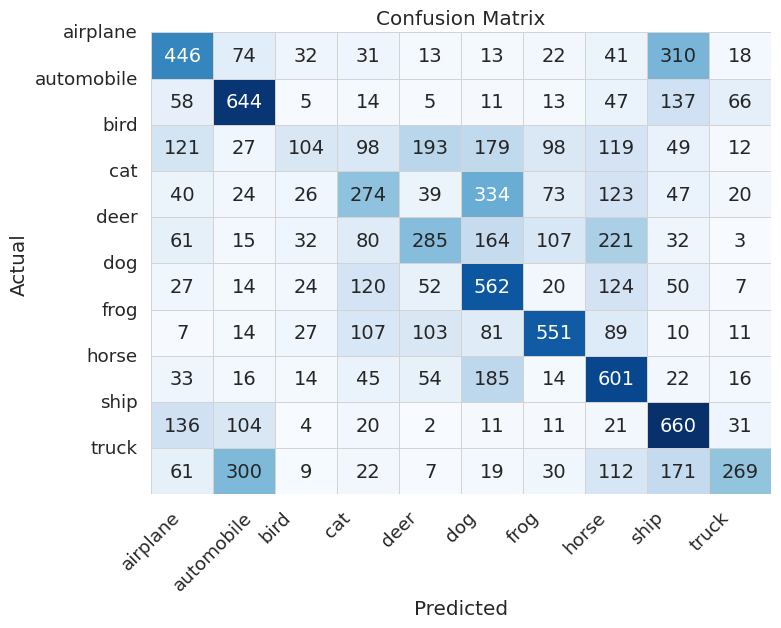

In [19]:
# Call the plot_confusion_matrix function
plot_confusion_matrix(preds, actuals, classes)